In [599]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [600]:
df = pd.read_csv('data/RV1_SIPIA.csv')

In [601]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=["Date"], inplace=True)

In [602]:
def plot_values(x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

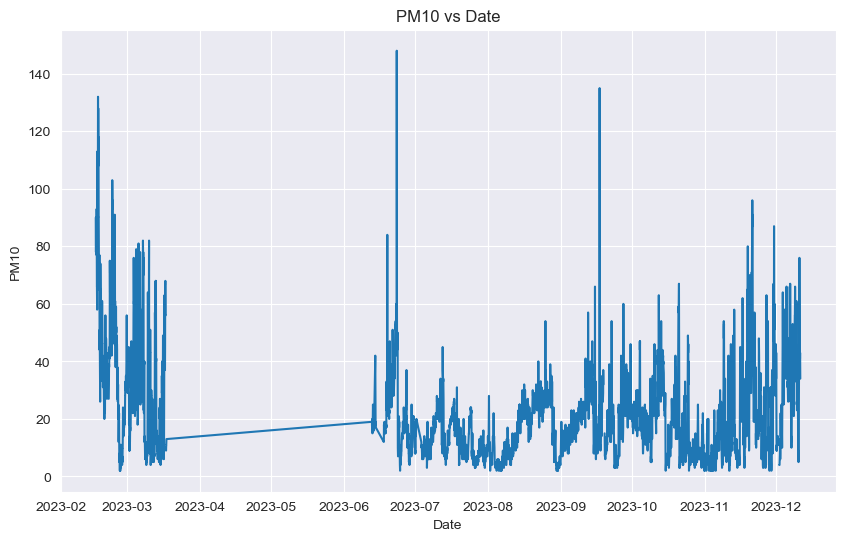

In [603]:
plot_values('Date', 'PM10')

In [604]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
42,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0
57,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0
55,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0
95,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0
88,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0


In [605]:
df.tail()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
763,2023-12-11 04:35:00+00:00,46.234818,15.267305,240.0,23.0,40.0,1.0,42.0
786,2023-12-11 05:35:00+00:00,46.234818,15.267305,240.0,24.0,38.0,1.0,41.0
713,2023-12-11 06:35:00+00:00,46.234818,15.267305,240.0,26.0,40.0,1.0,43.0
969,2023-12-11 07:35:00+00:00,46.234818,15.267305,240.0,33.0,35.0,1.0,37.0
1094,2023-12-11 08:35:00+00:00,46.234818,15.267305,240.0,46.0,28.0,1.0,34.0


In [606]:
df_weather = pd.read_csv('data/weather.csv')
df_weather.head()

,Date,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-01-01 00:15:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
1,2023-01-01 00:35:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
2,2023-01-01 01:15:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
3,2023-01-01 01:35:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
4,2023-01-01 02:15:00+00:00,4.8,92.0,3.6,1.9,0.0,0.0,0.0,992.5,10.0,9.2,141.0,1.8,0.356,0.0


In [607]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'], utc=True)

In [608]:
df = pd.merge(df, df_weather, on='Date', how='left')
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0,0.5,91.0,...,0.0,0.0,0.0,996.8,0.0,8.0,190.0,0.4,0.348,0.0
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0


In [609]:
df.isnull().sum()

Date                                0
Latitude                            0
Longitude                           0
Altitude                            0
NO2                               402
PM2.5                              67
O3                                297
PM10                               67
temperature_2m (°C)                 1
relative_humidity_2m (%)            1
dew_point_2m (°C)                   1
apparent_temperature (°C)           1
precipitation (mm)                  1
rain (mm)                           1
snowfall (cm)                       1
surface_pressure (hPa)              1
cloud_cover (%)                     1
wind_speed_10m (km/h)               1
wind_direction_10m (°)              1
soil_temperature_0_to_7cm (°C)      1
soil_moisture_0_to_7cm (m³/m³)      1
is_day ()                           1
dtype: int64

In [610]:
cols_to_fill = df.columns[df.isnull().any()].tolist()

In [611]:
cols_to_fill

['NO2',
 'PM2.5',
 'O3',
 'PM10',
 'temperature_2m (°C)',
 'relative_humidity_2m (%)',
 'dew_point_2m (°C)',
 'apparent_temperature (°C)',
 'precipitation (mm)',
 'rain (mm)',
 'snowfall (cm)',
 'surface_pressure (hPa)',
 'cloud_cover (%)',
 'wind_speed_10m (km/h)',
 'wind_direction_10m (°)',
 'soil_temperature_0_to_7cm (°C)',
 'soil_moisture_0_to_7cm (m³/m³)',
 'is_day ()']

In [612]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [613]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
dtype: int64

In [614]:
df["PM2.5/N02"] = df["PM2.5"] / df["NO2"]

df["PM2.5/03"] = df["PM2.5"] / df["O3"]

df['Season'] = df['Date'].dt.month.apply(lambda x: 'Winter' if (x == 12 or x <= 2) else
('Spring' if (3 <= x <= 5) else
 ('Summer' if (6 <= x <= 8) else
  ('Autumn' if (9 <= x <= 11) else None))))

df["Season"].astype('category')

df["Weekend"] = df["Date"].dt.dayofweek.apply(lambda x: 1 if (x == 5 or x == 6) else 0)

In [615]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Season,Weekend
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,0.857538,90.0,0.5,91.0,...,0.0,8.0,190.0,0.4,0.348,0.0,1.014286,82.795117,Winter,0
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.0,5.9,227.0,0.2,0.348,0.0,1.357143,38.000000,Winter,0
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.0,5.9,227.0,0.2,0.348,0.0,1.357143,38.000000,Winter,0
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.0,4.6,252.0,0.1,0.348,0.0,1.520833,36.500000,Winter,0
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.0,4.6,252.0,0.1,0.348,0.0,1.520833,36.500000,Winter,0


In [616]:
df = pd.get_dummies(df, columns=['Season'])

In [617]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Weekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,0.857538,90.0,0.5,91.0,...,0.4,0.348,0.0,1.014286,82.795117,0,False,False,False,True
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True


In [618]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          0
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [619]:
df.dropna(inplace=True)

In [620]:
np.any(np.isnan(df))

False

In [621]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.515519
PM2.5/03                          0.810381
PM2.5/N02                         0.572966
soil_moisture_0_to_7cm (m³/m³)    0.499661
dew_point_2m (°C)                 0.390765
soil_temperature_0_to_7cm (°C)    0.367383
NO2                               0.325878
apparent_temperature (°C)         0.324007
O3                                0.313897
temperature_2m (°C)               0.308555
Name: Information Gain Scores, dtype: float64

<Axes: >

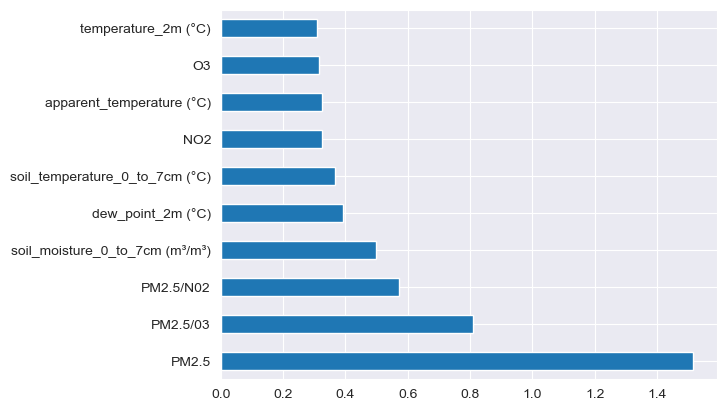

In [622]:
feature_importances.head(10).plot.barh()

In [623]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Box-Cox")

    # transform data
    data = boxcox(df[column], lmbda=0.0)

    # create after plots
    sns.distplot(data, ax=ax[1])
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()

In [624]:
def yeojohnson_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Yeo-Johnson")

    # transform data
    data = yeojohnson(df[column])

    # create after plots
    sns.distplot(data[0], ax=ax[1])
    ax[1].set_title("After Yeo-Johnson")

    # update dataframe
    df[column] = data[0]

    plt.show()

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

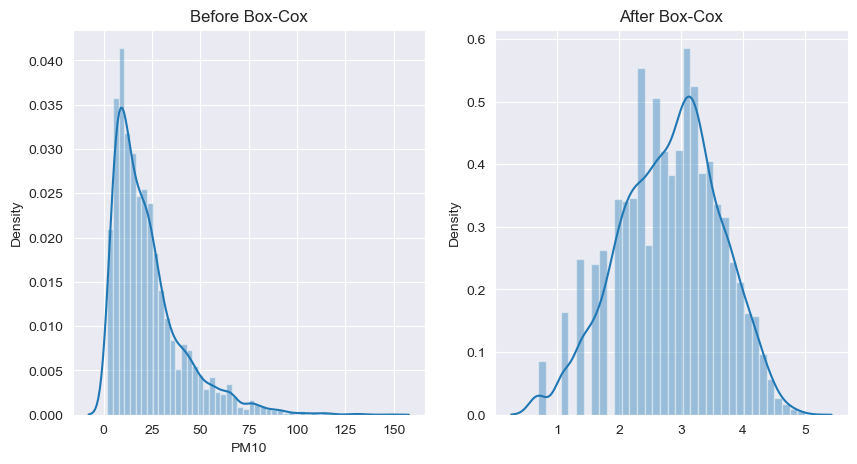

In [625]:
boxcox_transform('PM10')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

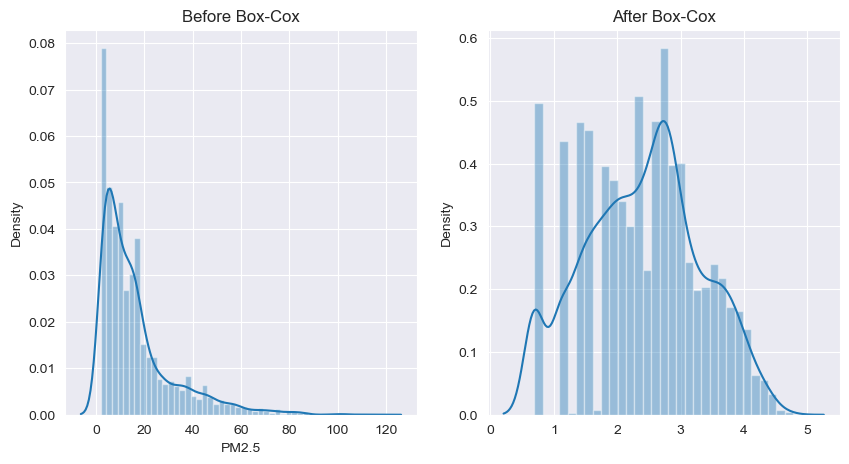

In [626]:
boxcox_transform('PM2.5')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

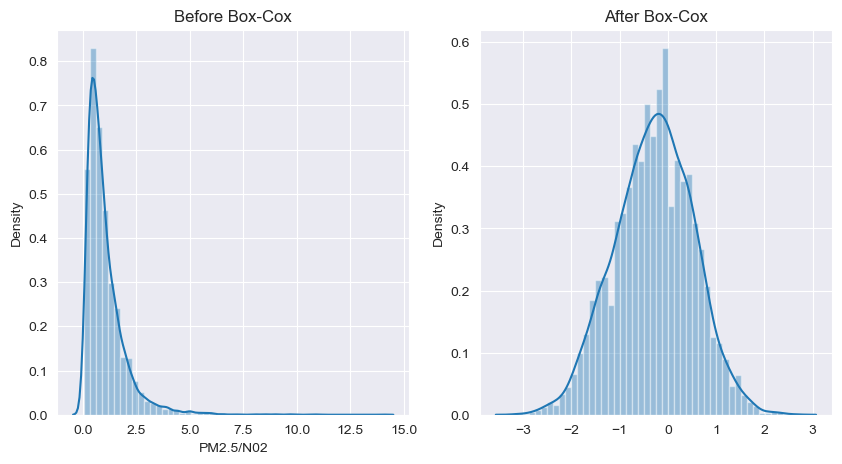

In [627]:
boxcox_transform('PM2.5/N02')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

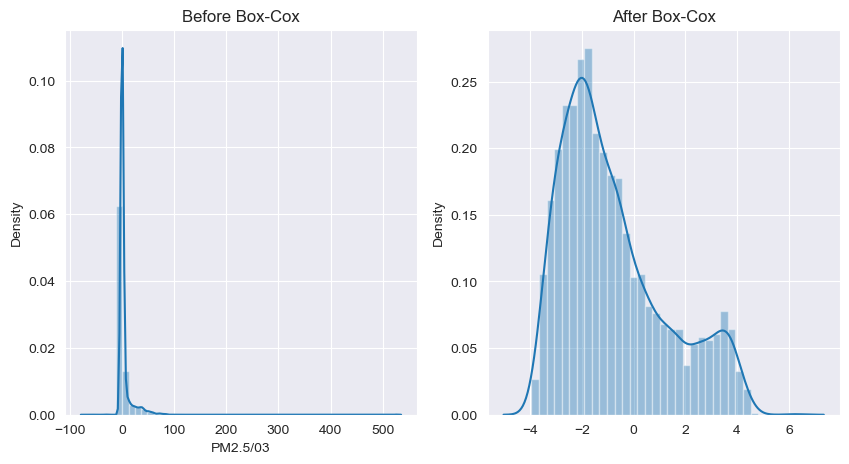

In [628]:
boxcox_transform('PM2.5/03')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

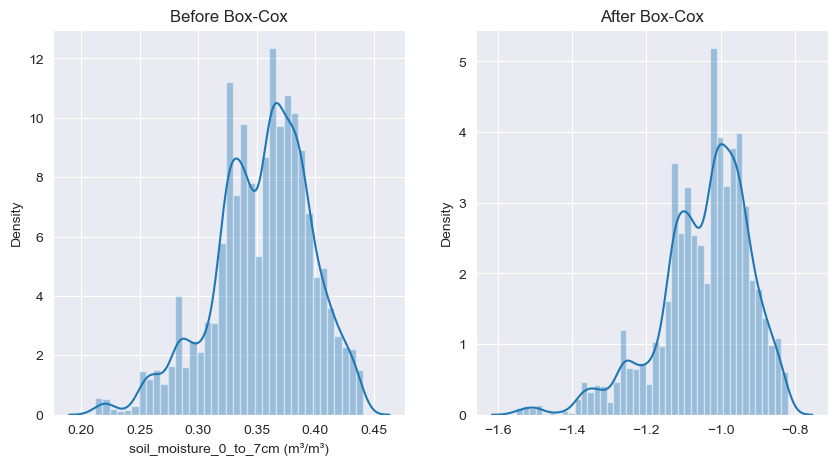

In [629]:
boxcox_transform('soil_moisture_0_to_7cm (m³/m³)')

In [630]:
top_features = feature_importances.head(4).index.tolist()

In [631]:
top_features

['PM2.5', 'PM2.5/03', 'PM2.5/N02', 'soil_moisture_0_to_7cm (m³/m³)']

In [632]:
target = 'PM10'

In [633]:
selected_features = top_features + [target]
dataset = df[selected_features]

In [634]:
dataset.head()

,PM2.5,PM2.5/03,PM2.5/N02,soil_moisture_0_to_7cm (m³/m³),PM10
0,4.262680,4.416369,0.014185,-1.055553,4.499810
1,4.330733,3.637586,0.305382,-1.055553,4.454347
2,4.330733,3.637586,0.305382,-1.055553,4.454347
3,4.290459,3.597312,0.419258,-1.055553,4.356709
4,4.290459,3.597312,0.419258,-1.055553,4.356709


In [635]:
dataset.shape

(5625, 5)

In [636]:
np.any(np.isnan(dataset))

True

In [637]:
dataset.isnull().sum()

PM2.5                             0
PM2.5/03                          4
PM2.5/N02                         0
soil_moisture_0_to_7cm (m³/m³)    0
PM10                              0
dtype: int64

In [638]:
dataset = dataset.dropna()

In [639]:
dataset.isnull().sum()

PM2.5                             0
PM2.5/03                          0
PM2.5/N02                         0
soil_moisture_0_to_7cm (m³/m³)    0
PM10                              0
dtype: int64

In [640]:
test_split = round(len(dataset) * 0.2)

In [641]:
test_split

1124

In [642]:
train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

In [643]:
train_data.shape

(4497, 5)

In [644]:
test_data.shape

(1124, 5)

In [645]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [646]:
def create_time_series(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0:data.shape[1]])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [647]:
measurements_in_day = 48
num_of_days = 1
window_size = measurements_in_day * num_of_days

In [648]:
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [649]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4449, 48, 5)
y_train shape: (4449,)
X_test shape: (1076, 48, 5)
y_test shape: (1076,)


In [650]:
def create_lstm_model(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="LSTM")
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def create_simple_rnn_model(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="RNN")
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def create_gru_model(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="GRU")
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [651]:
model_fns = [create_lstm_model, create_simple_rnn_model, create_gru_model]

In [652]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20, 30, 50],
    'units': [32, 64],
    'dropout_rate': [0.2, 0.3, 0.4],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop']
}

In [653]:
best_score = float('-inf')
best_model = None
best_grid_result = None
history = {}
best_models = {}

model_names = ['LSTM', 'RNN', 'GRU']

for idx, create_model_fn in enumerate(model_fns):

    model = KerasRegressor(build_fn=create_model_fn, verbose=0)

    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_iter=1,
        random_state=1234)

    grid_result = grid.fit(X_train, y_train, verbose=1, validation_data=(X_test, y_test))

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    history[model_names[idx]] = grid_result.best_estimator_.model.history.history
    best_models[model_names[idx]] = grid_result.best_estimator_.model

    if grid_result.best_score_ > best_score:
        best_score = grid_result.best_score_
        best_model = grid_result.best_estimator_.model
        best_grid_result = grid_result

print("Best model found:", best_model.name)
print("Best score:", best_score)

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/1679163261.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


Epoch 1/10
93/93 [==============================] - 5s 40ms/step - loss: 0.0310 - val_loss: 0.0574
Epoch 2/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0147 - val_loss: 0.0356
Epoch 3/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0121 - val_loss: 0.0549
Epoch 4/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0105 - val_loss: 0.0300
Epoch 5/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0097 - val_loss: 0.0260
Epoch 6/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0084 - val_loss: 0.0256
Epoch 7/10
93/93 [==============================] - 3s 37ms/step - loss: 0.0077 - val_loss: 0.0197
Epoch 8/10
93/93 [==============================] - 3s 38ms/step - loss: 0.0071 - val_loss: 0.0253
Epoch 9/10
93/93 [==============================] - 3s 37ms/step - loss: 0.0065 - val_loss: 0.0172
Epoch 10/10
93/93 [==============================] - 4s 39ms/step - loss: 0.0060 - val_loss: 0.0157
Epoch 1/1

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/1679163261.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


93/93 [==============================] - 2s 18ms/step - loss: 0.0232 - val_loss: 0.0416
Epoch 2/10
93/93 [==============================] - 2s 17ms/step - loss: 0.0114 - val_loss: 0.0242
Epoch 3/10
93/93 [==============================] - 1s 16ms/step - loss: 0.0089 - val_loss: 0.0189
Epoch 4/10
93/93 [==============================] - 1s 15ms/step - loss: 0.0075 - val_loss: 0.0233
Epoch 5/10
93/93 [==============================] - 2s 17ms/step - loss: 0.0067 - val_loss: 0.0181
Epoch 6/10
93/93 [==============================] - 2s 24ms/step - loss: 0.0062 - val_loss: 0.0153
Epoch 7/10
93/93 [==============================] - 2s 16ms/step - loss: 0.0058 - val_loss: 0.0198
Epoch 8/10
93/93 [==============================] - 2s 18ms/step - loss: 0.0054 - val_loss: 0.0176
Epoch 9/10
93/93 [==============================] - 2s 17ms/step - loss: 0.0049 - val_loss: 0.0109
Epoch 10/10
93/93 [==============================] - 1s 16ms/step - loss: 0.0050 - val_loss: 0.0166
Epoch 1/10
93/93 [==

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_54872/1679163261.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


Epoch 1/10
93/93 [==============================] - 6s 43ms/step - loss: 0.0127 - val_loss: 0.0265
Epoch 2/10
93/93 [==============================] - 4s 39ms/step - loss: 0.0078 - val_loss: 0.0170
Epoch 3/10
93/93 [==============================] - 3s 37ms/step - loss: 0.0070 - val_loss: 0.0162
Epoch 4/10
93/93 [==============================] - 4s 39ms/step - loss: 0.0060 - val_loss: 0.0126
Epoch 5/10
93/93 [==============================] - 4s 41ms/step - loss: 0.0055 - val_loss: 0.0133
Epoch 6/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 7/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0047 - val_loss: 0.0087
Epoch 8/10
93/93 [==============================] - 4s 39ms/step - loss: 0.0045 - val_loss: 0.0081
Epoch 9/10
93/93 [==============================] - 3s 37ms/step - loss: 0.0042 - val_loss: 0.0094
Epoch 10/10
93/93 [==============================] - 4s 38ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 1/1

In [654]:
def plot_history(history):
    plt.figure(figsize=(12, 8))
    for name, values in history.items():
        plt.plot(values['loss'], label=name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

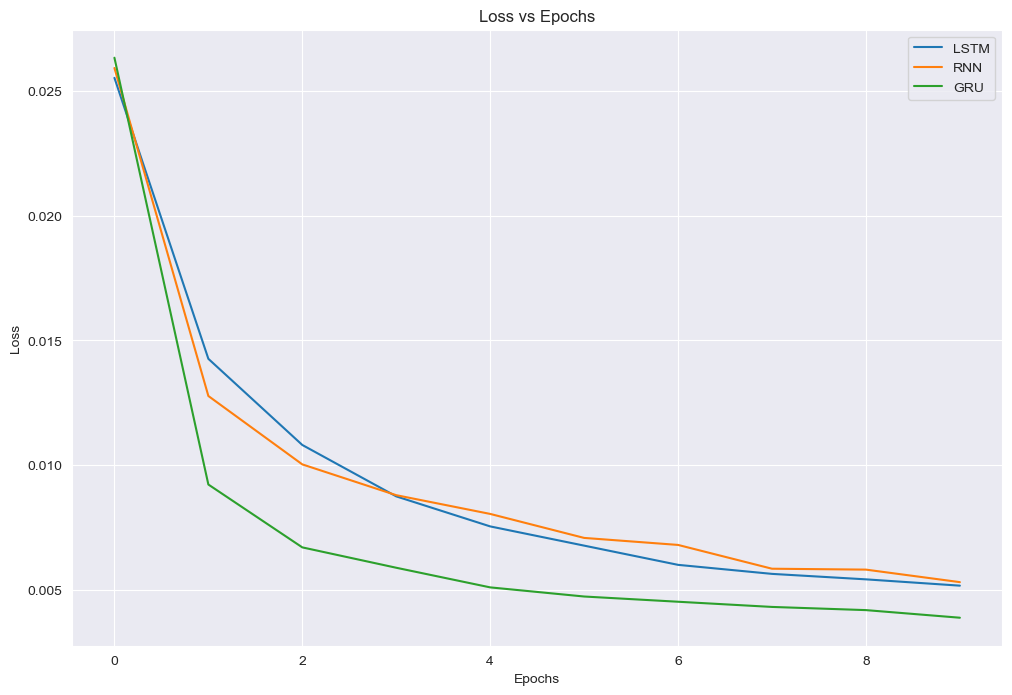

In [655]:
plot_history(history)

In [656]:
y_test_copies = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copies, (len(y_test), dataset.shape[1])))[:, 0]

In [657]:
results = {
    'MAE': [],
    'MSE': [],
    'EVS': []
}

for model in best_models.values():
    predicted = model.predict(X_test)

    prediction_copies = np.repeat(predicted, dataset.shape[1], axis=-1)
    predicted = scaler.inverse_transform(np.reshape(prediction_copies, (len(predicted), dataset.shape[1])))[:, 0]

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)

34/34 [==============================] - 1s 9ms/step
LSTM - MSE: 0.19
LSTM - MAE: 0.33
LSTM - EVS: 0.85
--------------------
34/34 [==============================] - 0s 4ms/step
RNN - MSE: 0.12
RNN - MAE: 0.27
RNN - EVS: 0.90
--------------------
34/34 [==============================] - 1s 7ms/step
GRU - MSE: 0.10
GRU - MAE: 0.23
GRU - EVS: 0.90
--------------------


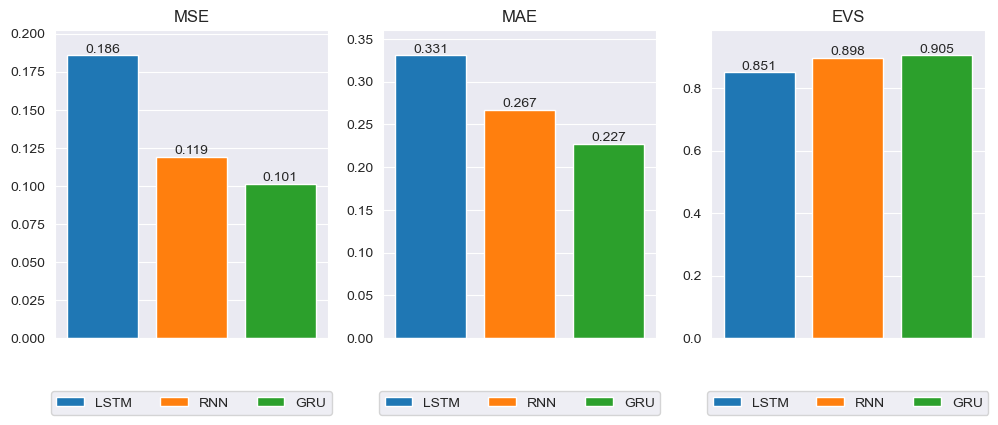

In [664]:
metrics = ['MSE', 'MAE', 'EVS']

width = 0.8
cols = len(metrics)

fig, axs = plt.subplots(1, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')

    for j, model in enumerate(model_names):
        value = results[metric][j][1]
        if value > max:
            max = value
        ax.bar(j, value, width, label=model)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')

    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

In [665]:
prediction = best_model.predict(X_test)

34/34 [==============================] - 0s 7ms/step


In [666]:
prediction_copies = np.repeat(prediction, dataset.shape[1], axis=-1)

In [667]:
prediction = scaler.inverse_transform(np.reshape(prediction_copies, (len(prediction), dataset.shape[1])))[:, 0]

In [668]:
original_values_copies = np.repeat(y_test, dataset.shape[1], axis=-1)

In [669]:
original_values = scaler.inverse_transform(np.reshape(original_values_copies, (len(y_test), dataset.shape[1])))[:, 0]

In [670]:
dates = df['Date']

In [680]:
df_output = pd.DataFrame({'Date': dates[-test_split + window_size:], 'Actual': original_values,
                          'Predicted': prediction})

In [681]:
df_output.head()

,Date,Actual,Predicted
4549,2023-10-27 13:35:00+00:00,7.255691,1.462372
4550,2023-10-27 14:35:00+00:00,3.519481,1.595489
4551,2023-10-27 15:35:00+00:00,6.345814,1.039673
4552,2023-10-27 16:35:00+00:00,3.519481,1.211571
4553,2023-10-27 17:35:00+00:00,3.519481,0.935586


In [683]:
def plot_results():
    plt.figure(figsize=(12, 8))
    plt.plot(df_output['Date'], df_output["Actual"], label='Actual')
    plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('PM10')
    plt.title('PM10 vs Time')
    plt.legend()
    plt.show()

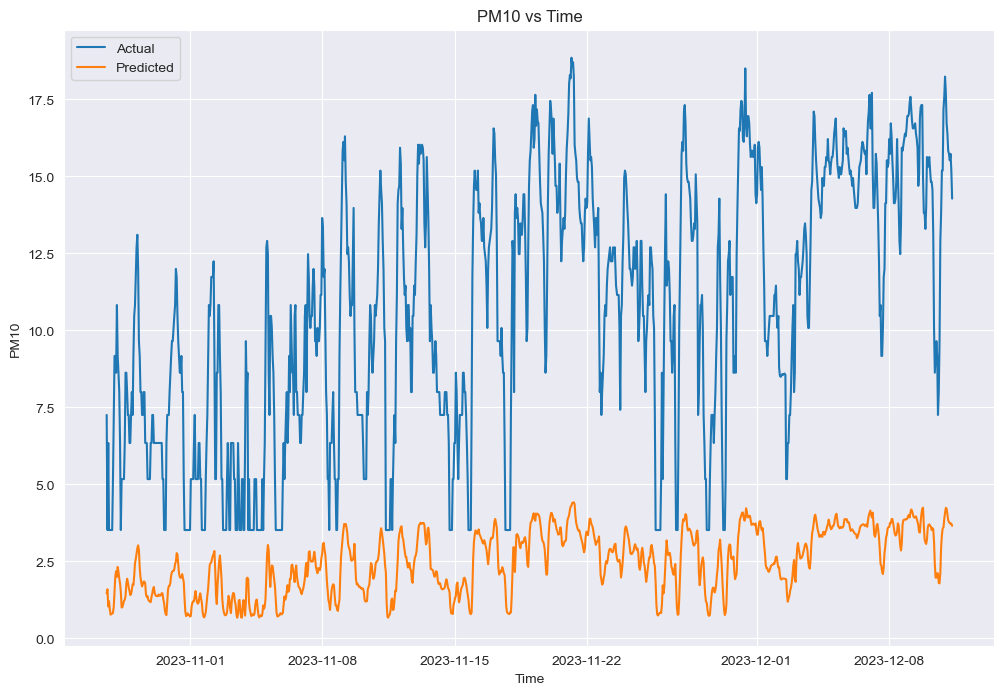

In [684]:
plot_results()

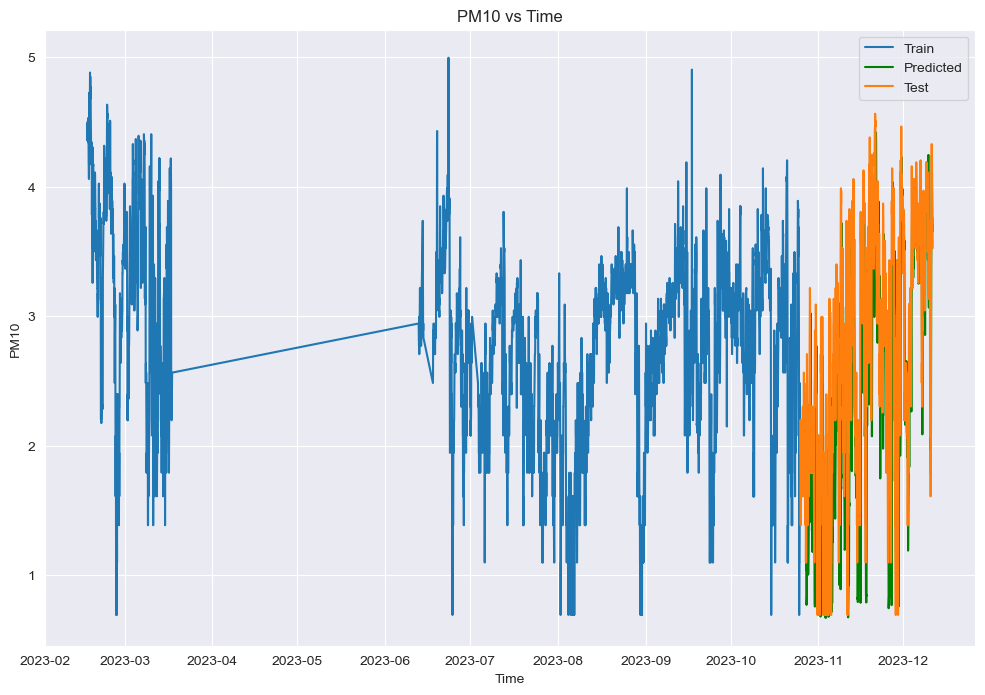

In [688]:
plt.figure(figsize=(12, 8))
plt.plot(df["Date"].iloc[:-test_split], df["PM10"].iloc[:-test_split], label='Train')
plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted', color='green')
plt.plot(df["Date"].iloc[-test_split:], df["PM10"].iloc[-test_split:], label='Test')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.title('PM10 vs Time')
plt.legend()
plt.show()